
### T2 Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2021  

In [1]:
%matplotlib widget
import os
import spec_funcs as sf
import fit_funcs as ff
import filter_funcs as fil
import numpy as np
import matplotlib.pyplot as mp
from scipy.signal import fftconvolve
mp.style.use('signature.mplstyle')
from filter_funcs import smooth_data, moving_av

path = r"C:\Users\sk88\Desktop\YSO_T2"


##### Import Data  

        Load data sets & extract time and echo data


In [2]:
_, files = sf.dir_interogate(path)
file_paths = [os.path.join(path, x) for x in files]
data_lists = [sf.open_excel(file_path) for file_path in file_paths]
length_data_lists = range(len(data_lists))
time_lists = [data_lists[n][0] for n in length_data_lists]
trigger_lists = [data_lists[n][1] for n in length_data_lists]
reference_lists = [data_lists[n][3] for n in length_data_lists]
transmitted_lists = [data_lists[n][2] for n in length_data_lists]
trans_smoothed = [smooth_data(trans_list, 100) for trans_list in transmitted_lists]


##### Check channel assignment  

        Plot one of each channel to check assignment is correct for calculations


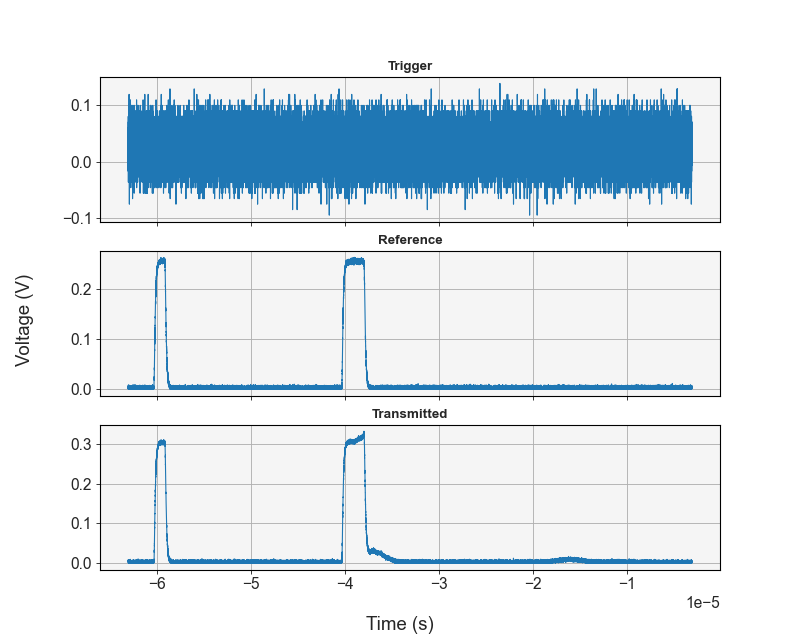

In [3]:
fig, ax = mp.subplots(nrows=3, ncols=1, sharex='all')
fig.supxlabel('Time (s)')
fig.supylabel('Voltage (V)')

ax[0].set_title('Trigger')
ax[0].plot(time_lists[0], trigger_lists[0])
ax[1].set_title('Reference')
ax[1].plot(time_lists[0], reference_lists[0])
ax[2].set_title('Transmitted')
ax[2].plot(time_lists[0], transmitted_lists[0])

In [4]:
# find the trigger indexes
start_index = [sf.find_trigger(trigger_list, modifier=0.9, edge='rise') for trigger_list in trigger_lists]
stop_index = [sf.find_trigger(trigger_list, modifier=0.9, edge='fall') for trigger_list in trigger_lists]
# trim the data to focus on the echo
time_cut_lists = [time_list[start:stop] for time_list, start, stop in zip(time_lists, start_index, stop_index)]
ref_time_lists = [time_list[start:stop] for time_list, start, stop in zip(time_lists, start_index, stop_index)]
trans_cut_lists = [trans_list[start:stop] for trans_list, start, stop in zip(transmitted_lists, start_index, stop_index)]
ref_cut_lists = [ref_list[start:stop] for ref_list, start, stop in zip(reference_lists, start_index, stop_index)]
smooth_cut_lists = [smooth_list[start:stop] for smooth_list, start, stop in zip(trans_smoothed, start_index, stop_index)]

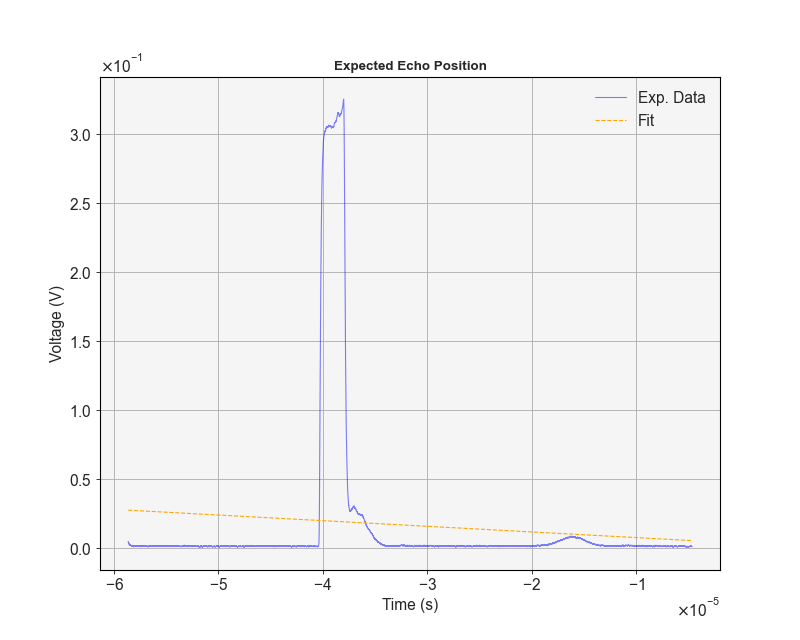

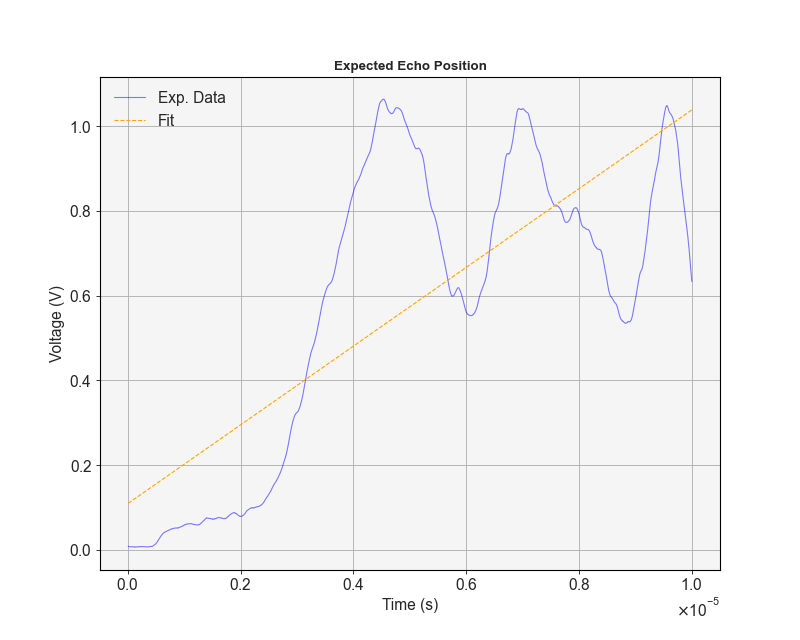

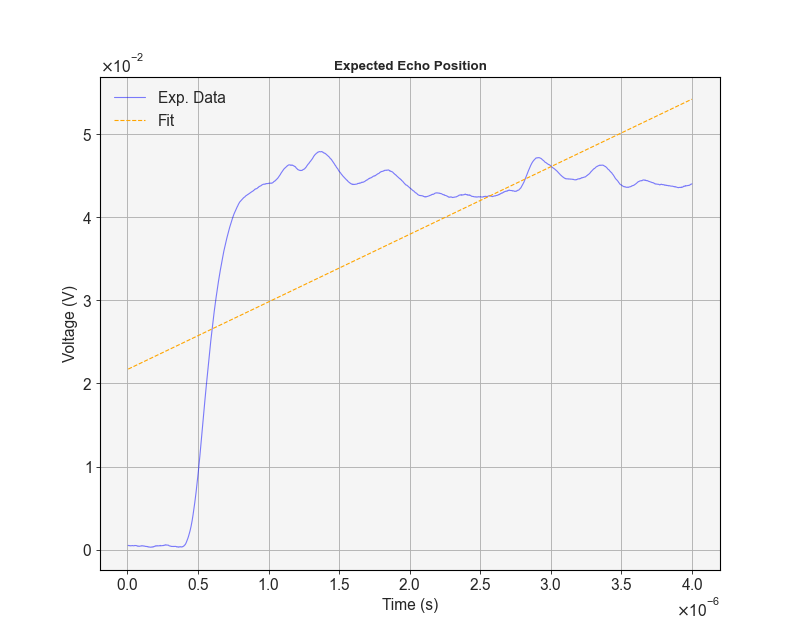

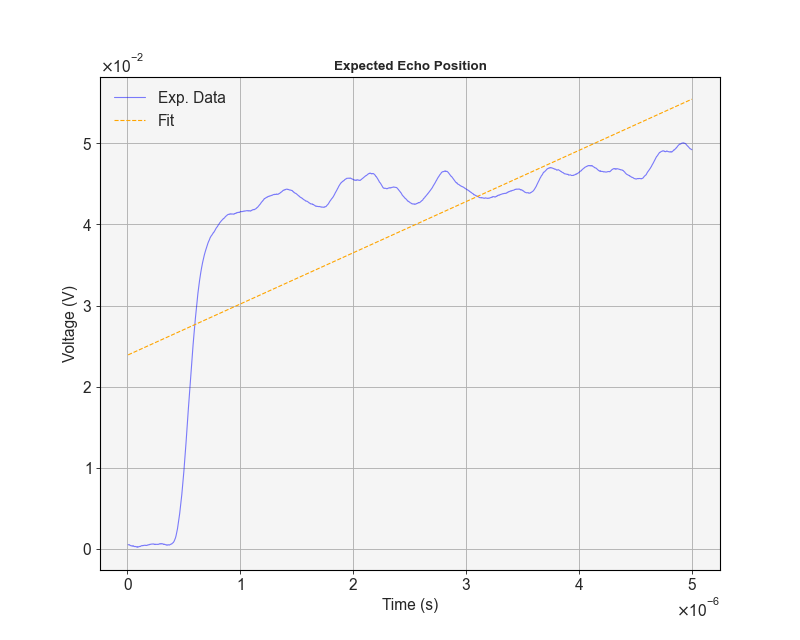

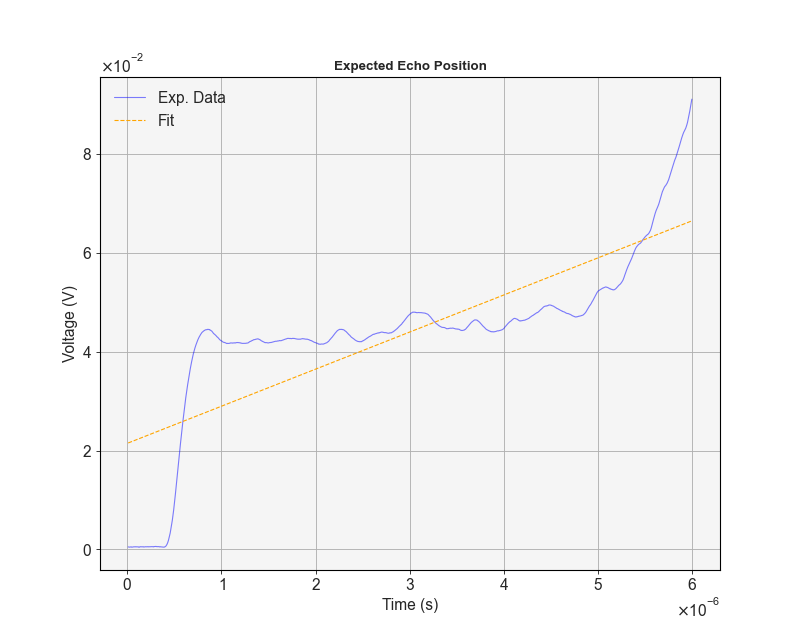

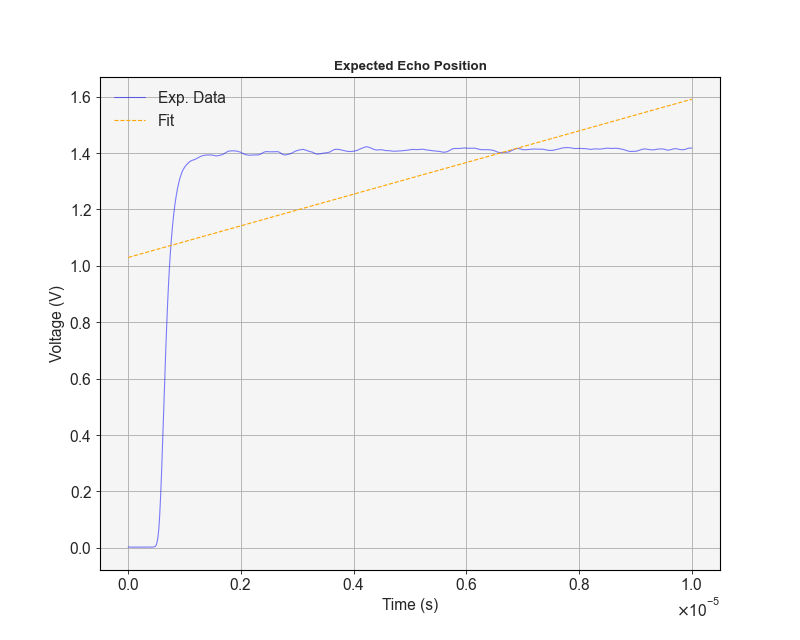

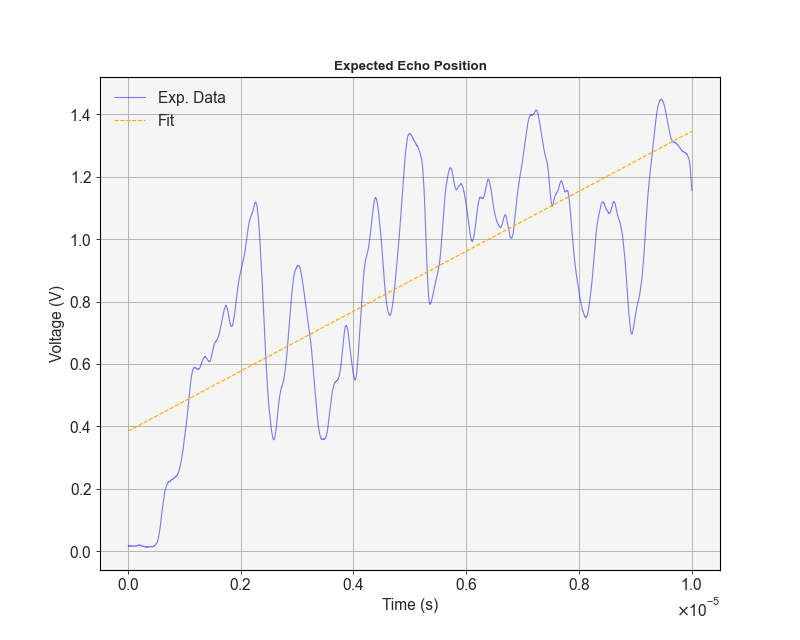

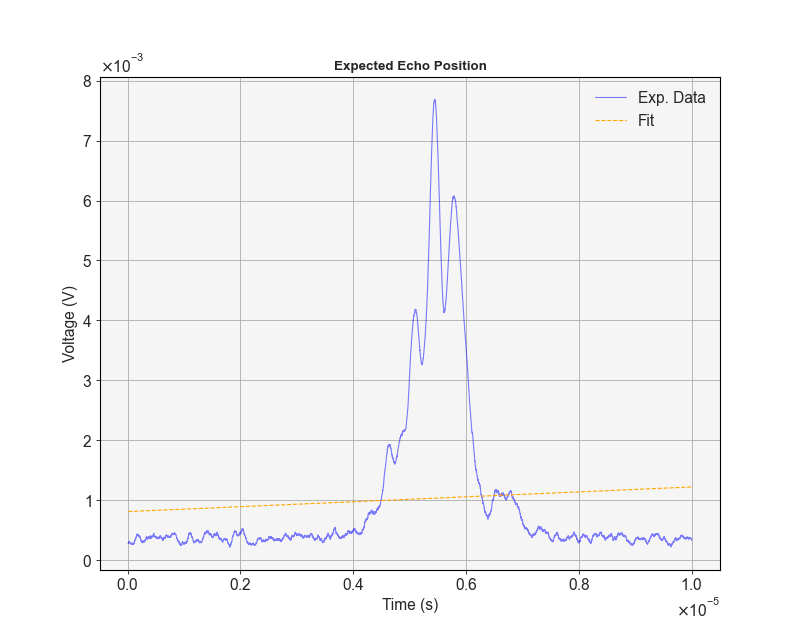

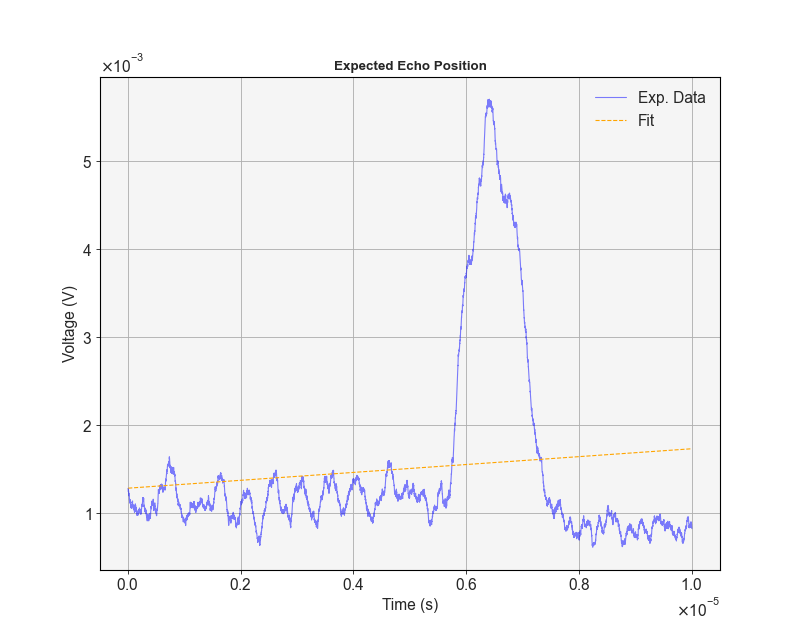

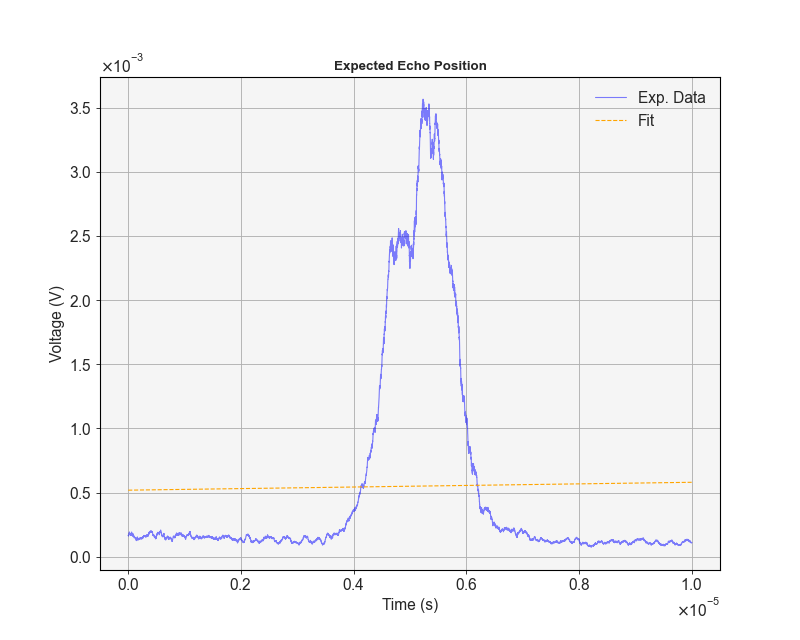

In [5]:
straight_fit = [ff.fit_straight(time, smooth_cut_lists[idx]) for idx, time in enumerate(time_cut_lists)]

# loop over references - fit and plot data
for idx, time in enumerate(time_cut_lists):
    
    fig, ax = mp.subplots()
    ax.set_title('Expected Echo Position')
    ax.plot(time, smooth_cut_lists[idx], color='blue', alpha=0.5, label='Exp. Data')
    ax.plot(time, ff.straight(np.array(time), *straight_fit[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText = True)
    ax.set(xlabel='Time (s)', ylabel='Voltage (V)')
    ax.legend()

In [6]:
gaussian_fit = ff.fit_gauss(time_cut_lists[-1], trans_cut_lists[-1], params=(np.max(trans_cut_lists[-1]), 0, 0.5E-5, 0.1E-5))

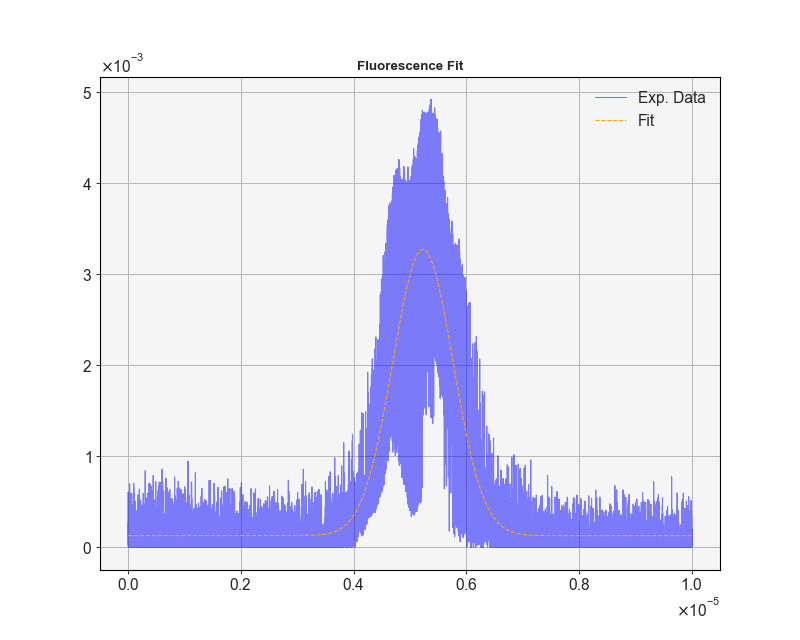

In [7]:
fig, ax = mp.subplots()

ax.set_title('Fluorescence Fit')
ax.plot(time_cut_lists[-1], trans_cut_lists[-1], color='blue', alpha=0.5, label='Exp. Data')
ax.plot(time_cut_lists[-1], ff.gaussian(np.array(time_cut_lists[-1]), *gaussian_fit[0]), color='orange', linestyle='--', alpha=1, label='Fit')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText = True)
ax.legend()

In [8]:
from scipy.integrate import trapz, cumtrapz

In [9]:
area = trapz(trans_cut_lists[-1], time_cut_lists[-1])

In [10]:
area

5.487345990914808e-09

In [11]:
corrected_zip = zipped_data = zip(time_cut_lists[-2:], trans_cut_lists[-2:])
gaussian_fit = [ff.fit_gauss(time, trans) for time, trans in zipped_data]
# loop over references - fit and plot data
for idx, time in enumerate(time_cut_lists):
    # zip data together for list comprehension

    fig, ax = mp.subplots()
    
    ax.set_title('Fluorescence Fit')
    ax.plot(time, trans_cut_lists[idx], color='blue', alpha=0.5, label='Exp. Data')
    ax.plot(time, ff.gaussian(np.array(time), *gaussian_fit[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText = True)
    ax.legend()


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [ ]:
fit, fit_err = ff.fit_straight(cut_10M_x, cut_10M_0)
straight = ff.straight(cut_10M_x, *fit)
mp.figure()
mp.plot(cut_10M_x, cut_10M_0)
mp.plot(cut_10M_x, straight)

fixed = np.asarray(cut_10M_0) - np.asarray(straight)

mp.figure()
mp.plot(fixed)

In [ ]:
T = cut_10M_x[1]-cut_10M_x[0] # time interval
sr = 1/T # sampling rate
N = np.size(cut_10M_x)
M = 101
freq = sf.fftfreq(N, T)

print(T, sr, N)

In [ ]:
low_pass = 50E6
trans_band = 25E5
b = trans_band/sr
lfc = low_pass/sr
lM = int(np.ceil((4/b)))
lpf = fil.low_pass(lM, lfc)
nlp = len(lpf) // 2
ma = fil.moving_av(M)
nma = len(ma)//2
filtered = fftconvolve(lpf, fixed)
smoothed = fftconvolve(ma, fixed)

fftd = np.sqrt(np.abs(sf.fft(filtered)))
ffts = np.sqrt(np.abs(sf.fft(smoothed)))

In [ ]:
# filtered data
mp.figure()
mp.title('Low-Pass')
mp.xlabel('time (s)')
mp.ylabel('Intesity AU')
mp.plot(cut_10M_x, filtered[nlp:-nlp])

mp.figure()
mp.title('FFT of Low-Pass')
mp.xlabel('freq (Hz)')
mp.ylabel('Intensity AU')
mp.plot(freq[0:500], fftd[0:500])

# smoothed data
mp.figure()
mp.title('Smoothed')
mp.xlabel('time (s)')
mp.ylabel('Intesity AU')
mp.plot(cut_10M_x, smoothed[nma:-nma])

mp.figure()
mp.title('FFT of Smoothed')
mp.xlabel('freq (Hz)')
mp.ylabel('Intensity AU')
mp.plot(freq[0:500], ffts[0:500])

mp.figure()
mp.title('Fixed')
mp.xlabel('time (s)')
mp.ylabel('Intesity AU')
mp.plot(cut_10M_x, fixed)

mp.figure()
mp.title('FFT Combined')
mp.xlabel('freq (Hz)')
mp.ylabel('Intensity AU')
mp.plot(freq[0:100], np.sqrt(np.abs(sf.fft(fixed)))[0:100], label='FFT fixed')
mp.plot(freq[0:100], fftd[0:100], label='FFT filtered')
mp.plot(freq[0:100], ffts[0:100], label='FFT smoothed and filtered')
mp.legend(loc='best')